In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read in all the words
words = open('karpathy/makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
#build the vocabulary of hcaracters and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

27


In [5]:
block_size = 3
def build_dataset(words):
    X,Y = [],[]
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  #crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
            
Xtr, Ytr = build_dataset(words[:n1])    
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
#MLP revisited
n_embd = 10  #the dimensionality of the character embedding vectors
n_hidden = 200  #the number of neurons in the hidden layer of the 
#需要进行初始化的优化
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),generator = g)
W1 = torch.randn((n_embd * block_size,n_hidden),generator = g) * (5/3)/((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden, generator = g) * 0.01  #防止神经元过度饱和，以至于梯度消失而死亡
W2 = torch.randn((n_hidden,vocab_size),generator = g) * 0.01  
b2 = torch.randn(vocab_size,generator = g) * 0  #使得27个字符初始的概率保持，初始化loss能够减小

#缩放#BatchNorm parameters
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) #number of parameters in total
for p in parameters:
    p.requires_grad = True
    
    

12097


In [7]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
stepi = []
for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator = g)
    Xb, Yb = Xtr[ix],Ytr[ix]
    #forward pass
    emb = C[Xb]  
    embcat = emb.view(emb.shape[0],-1)
    #linear layer 权重层
    hpreact = embcat @ W1 #+ b1  #hidden layer per-activation
    #BatchNorm layer  归一化层（——可以散布于整个神经网络的层）
    bnmeani = hpreact.mean(0,keepdim = True)   #当使用这一步时，便不再需要bias，因为此时nb项会因为mean以后再减去mean而不起任何作用
    bnstdi = hpreact.std(0,keepdim = True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias #batch normalizationl
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnmean_running +0.001 * bnstdi  #0.001:torch.nn当中的momentum
        #关于momentum:如果使用稍高一些的batch_size,那么则可以尝试使用更高的momentum(如0.1)
        #如果在较小的批量上选择较大的momentum,那么可能会使bnmeam_running和bnstd_running在训练期间产生较大波动
        #从而使得模型不能正确收敛
    #Non-linearity  #非线性层
    h = torch.tanh(hpreact)  #hidden layer
    logits = h @ W2 + b2  #output layer
    loss = F.cross_entropy(logits, Yb)  #loss function
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    if i%10000 == 0: # print every once in a while
        print(f'{i:7d} / {max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)

      0 /  200000:3.3239
  10000 /  200000:2.0322
  20000 /  200000:2.5675
  30000 /  200000:2.0125
  40000 /  200000:2.2446
  50000 /  200000:1.8897
  60000 /  200000:2.0785
  70000 /  200000:2.3681
  80000 /  200000:2.2918
  90000 /  200000:2.0238
 100000 /  200000:2.3673
 110000 /  200000:2.3132
 120000 /  200000:1.6414
 130000 /  200000:1.9311
 140000 /  200000:2.2231
 150000 /  200000:2.0027
 160000 /  200000:2.0997
 170000 /  200000:2.4949
 180000 /  200000:2.0199
 190000 /  200000:2.1707


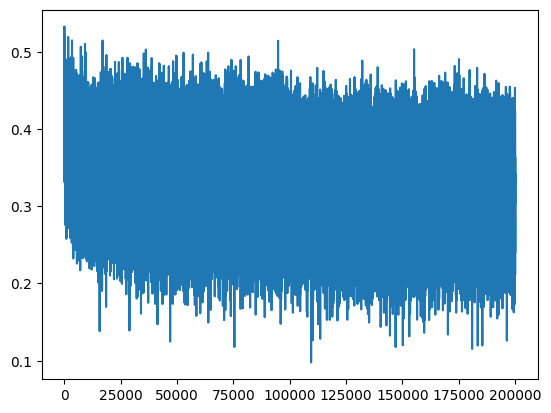

In [8]:
plt.plot(stepi,lossi)

In [10]:
#caliberate the batch norm at the end of training
#在训练结束后对批量归一化（Batch Normalization）进行校准
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1
    #measure the mean over the entire training set
    bnmean = hpreact.mean(0,keepdim = True)
    bnstd = hpreact.std(0,keepdim = True)

In [12]:
@torch.no_grad()  #让下面这个函数执行的所有变量都无grad也就是no_grad,从而不能进行反向传播
#adecorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1  #hidden layer per-activation
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias #batch normalizationl
    h = torch.tanh(hpreact)  #hidden layer
    logits = h @ W2 + b2  #output layer
    loss = F.cross_entropy(logits, y)  #loss function
    print(split,loss.item())
split_loss('train')
split_loss('val')

train 5.513614177703857
val 5.5102763175964355


In [13]:
# sample from the model 
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1)  #，view(1, -1)是将emb的维度调整为1行，剩下的维度自动计算得出。
        logits = h @ W2 + b2 #最终输出 logits
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(p, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

NameError: name 'b1' is not defined

原本模型存在的问题：
1。初始值设置太不合理，真正的loss应该是

In [ ]:
-torch.tensor(1/27.0).log()

下面这个例子用于说明：

In [ ]:
#4-dimensional example of the issue
logits = torch.tensor([0.0,0.0,0.0,0.0])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
probs, loss

如果将其中一个值突然增大：

In [ ]:
logits = torch.tensor([0.0,0.0,5.0,0.0])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
probs, loss

若是刚好增大要求的值的概率，那么loss就会变得很小

In [ ]:
logits = torch.tensor([5.0,0.0,0.0,0.0])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
probs, loss

In [ ]:
若是增加别的变量的概率，损失就会变得很大；并且，若其中一个变得很大，起始loss可能会变为无穷
所以，为了缩小logits, logits = h @ W2 + b2  #output layer
那么，则要尽量缩小w2和b2

In [ ]:
2.张量h中值多数为-1或者1

In [ ]:
plt.hist(h.view(-1).tolist(), 50);

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

借助makemore中的tanh函数来理解，如果所有的t都趋向于0,那么grad就不能优化，从而实现不了梯度下降（梯度小时）  
  def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

In [ ]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

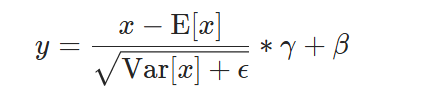

In [8]:
#let's train a deeper network
#模仿pytorch的方法构建模型：
class linear:
    def __init__(self,fan_in,fan_out,bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self,dim,eps = 1e-5,momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
#self.training 控制着 BatchNorm1d 层的工作模式。当 self.training 为 True 时，表示处于训练模式，
#会根据当前输入 x 计算均值和方差，并更新 running_mean 和 running_var。
#而当 self.training 为 False 时，表示处于推理或测试模式，使用之前计算好的 running_mean 和 running_var 来进行标准化。
        #parameters
        self.gamma = torch.zeros(dim)
        self.beta = torch.ones(dim)
        #buffers
        self.running_mean = torch.zeros(dim)
        self.running_ver = torch.ones(dim)
        
    def __call__(self,x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0,keepdim = True)
            xvar = x.var(0,keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
#xhat 是标准化后的输入数据，通过将 x 减去均值 xmean 并除以标准差的平方根（加上一个很小的值 eps 防止除以零）得到。
        self.out = self.gamma *xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1- self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
n_embd = 10
n_hidden = 100 # the number of neurons in the hidden layer of MLP
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),generator = g)
layers = [  #使用六层多层感知机
    linear(n_embd * block_size, n_hidden),Tanh(),
    linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    linear(n_hidden, vocab_size),BatchNorm1d(vocab_size),
]  #如果线性层之间不用tanh()层连接的话，那么许多线性层叠加之后就会产生一个线性层的效果

with torch.no_grad():  #这段代码的含义见下图
    #last layer: make less confident
    layers[-1]. gamma*= 0.1
    #all other layers : apply again
    for layer in layers[:-1]:
        if isinstance(layer,linear):
            layer.weight *= 0.1#5/3   #因为tanh的压扁的作用，需要一些gain来对抗挤压
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True    

46924


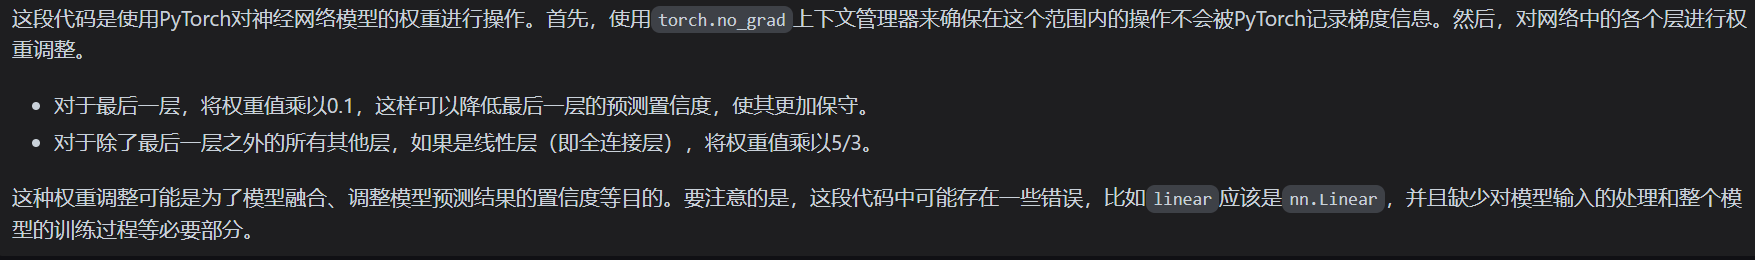

In [11]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
        lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log().item() for p in parameters])

AttributeError: 'BatchNorm1d' object has no attribute 'running_var'

print('layer  %d(%10s):mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer._class_.__name__, running_mean, running_var))
这行代码是一个 Python 的字符串格式化操作，它基于给定的参数生成一个格式化的字符串。让我们逐个解释它：

%d: 这是一个占位符，表示将要格式化的参数是一个整数。
%10s: 这个占位符表示将要格式化的参数是一个字符串，且宽度为 10，不足 10 的部分会用空格填充。
%+.2f: 这个占位符表示将要格式化的参数是一个浮点数，前面带有正负号，小数点后保留 2 位。
%.2f: 这个占位符也表示将要格式化的参数是一个浮点数，小数点后保留 2 位。
%%: 这个是转义字符，用来表示一个百分号 %。
现在让我们看看如何使用这些占位符来格式化字符串：

(i, layer._class_.__name__): 这里是传入的参数，i 是一个整数，layer._class_.__name__ 是一个字符串。
mean: 这是一个字符串。
std: 这是一个浮点数。
saturated: 这是一个百分比，浮点数表示。
综合起来，这行代码生成一个字符串，其中包含了参数 i、layer._class_.__name__、mean、std 和 saturated 的值。格式化后的字符串形式为："layer i(layer.class.name): mean +mean, std std, saturated: saturated%"。

layer  1(      Tanh):mean +0.03, std 0.84, saturated: 43.59%
layer  3(      Tanh):mean -0.00, std 0.82, saturated: 38.62%
layer  5(      Tanh):mean +0.01, std 0.83, saturated: 38.97%
layer  7(      Tanh):mean +0.01, std 0.74, saturated: 31.94%
layer  9(      Tanh):mean -0.05, std 0.57, saturated: 16.56%


Text(0.5, 1.0, 'activation distribution')

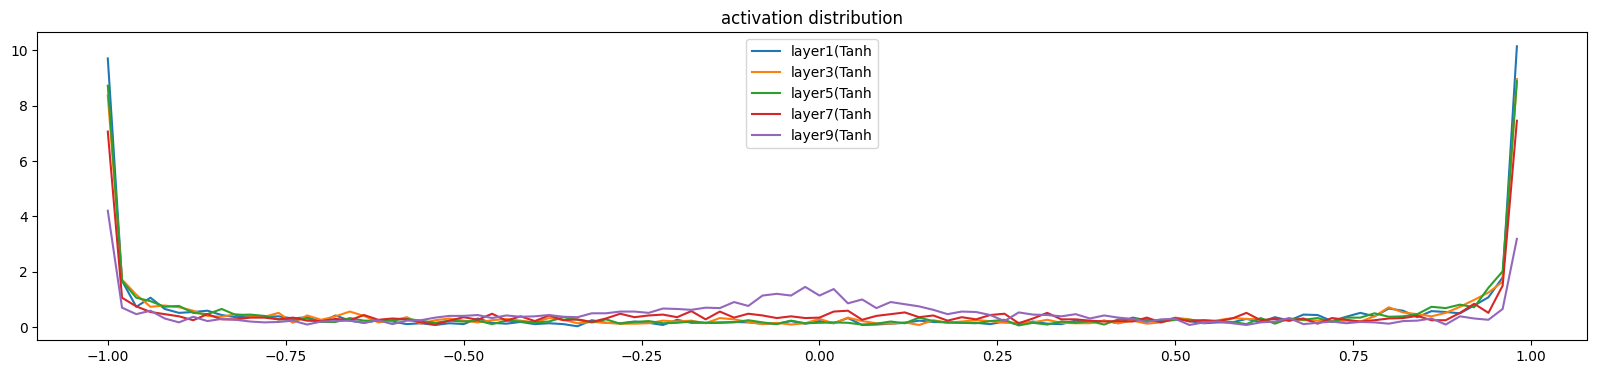

In [15]:
#visualize histograms
plt.figure(figsize=(20,4))
legends = []  #创建一个空列表，用于存储图例信息
for i, layer in enumerate(layers[:-1]):  #exclude the output layer(softmax layer)
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer  %d(%10s):mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        #saturate：处于5%较好(是由于用了合适的gain的缘故)
        hy, hx = torch.histogram(t, density = True)
        #使用PyTorch的torch.histogram()函数计算当前层输出的直方图，参数density = True表示计算概率密度
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i}({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


In [16]:
#visualize histograms
plt.figure(figsize=(20,4))
legends = []  #创建一个空列表，用于存储图例信息
for i, layer in enumerate(layers[:-1]):  #exclude the output layer(softmax layer)
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer  %d(%10s):mean %+f, std %e '% (i, layer.__class__.__name__, t.mean(), t.std()))
        #saturate：处于5%较好
        hy, hx = torch.histogram(t, density = True)
        #使用PyTorch的torch.histogram()函数计算当前层输出的直方图，参数density = True表示计算概率密度
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i}({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

C:\Users\qianc\AppData\Local\Temp\ipykernel_11444\3761423705.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  t = layer.out.grad


AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

weight   (27, 10) | mean +0.000785 | std 1.224646e-02 | grad:data ratio 8.940011e-03
weight  (30, 100) | mean -0.000165 | std 8.154726e-03 | grad:data ratio 1.729563e-02
weight (100, 100) | mean +0.000068 | std 4.512630e-03 | grad:data ratio 1.990494e-02
weight (100, 100) | mean +0.000026 | std 4.913880e-03 | grad:data ratio 2.492067e-02
weight (100, 100) | mean -0.000015 | std 6.506111e-03 | grad:data ratio 3.657749e-02
weight (100, 100) | mean +0.000060 | std 7.541931e-03 | grad:data ratio 5.035750e-02
weight  (100, 27) | mean -0.000000 | std 1.784789e-02 | grad:data ratio 8.119170e-02


Text(0.5, 1.0, 'activation distribution')

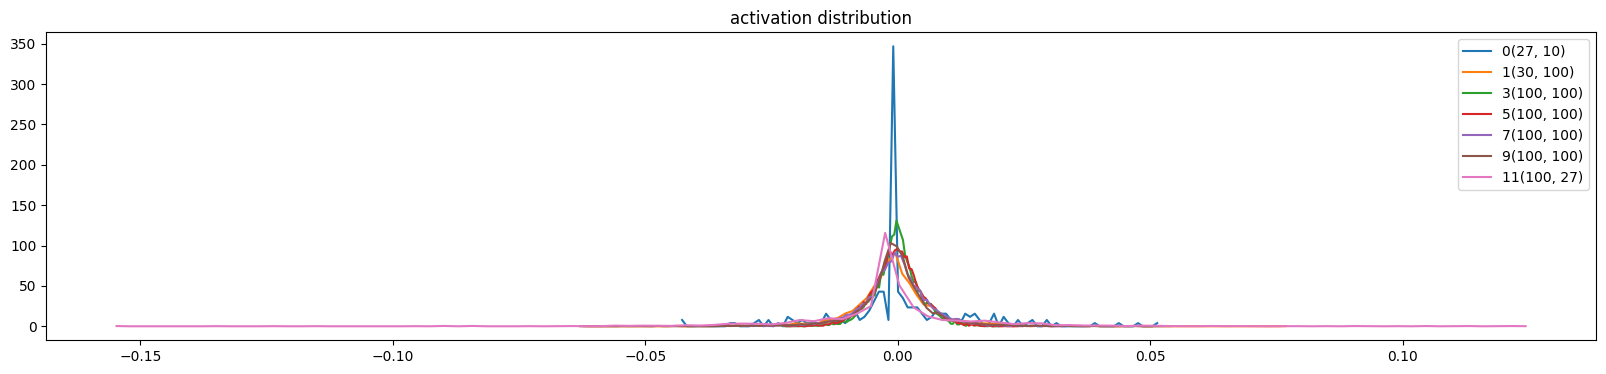

In [23]:
#visualize histograms
plt.figure(figsize=(20,4))
legends = []  #创建一个空列表，用于存储图例信息
for i, p in enumerate(parameters):  
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape),t.mean(),t.std(),t.std()/p.std()))
        #saturate：处于5%较好
        hy, hx = torch.histogram(t, density = True)
        #使用PyTorch的torch.histogram()函数计算当前层输出的直方图，参数density = True表示计算概率密度
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i}{tuple(p.shape)}')
plt.legend(legends);
plt.title('activation distribution')


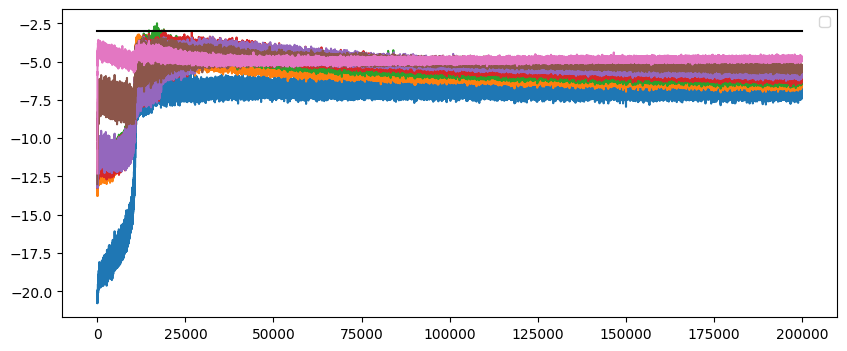

In [24]:
plt.figure(figsize = (10,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range (len(ud))])
plt.plot([0,len(ud)],[-3, -3],'k')  #these ratios should be ~1e-3,indicate on plot
#如果在对数图上小于负三，那么证明训练结果非常慢
#可以通过改变gain或者是batch_size来改变速度大小  gain越大,batch_size越小
#如果过大那么有可能是learning rate过大了
plt.legend(legends);